In [ ]:
#LETS WORK WITH CIFAR 10 DATA 

# OBJECTIVE 

Train CIFAR 10 with RESNET using Augmentation technique :Albumentation,GRADCAM ,CUTOUT 

->Pick your last code

->Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)

->Use this repo: https://github.com/davidtvs/pytorch-lr-finder
Move LR Finder code to your modules

->Implement LR Finder (for SGD, not for ADAM)
Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

->Find best LR to train your model

->Use SDG with Momentum

->Train for 50 Epochs. 

->Show Training and Test Accuracy curves

->Target 88% Accuracy.

->Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.
 

In [ ]:
#STEP1:Install Albumentation

In [ ]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)


In [ ]:
#STEP 2 :Import in built library 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor




In [ ]:
#STEP 3 : DELETE OLD GIT FOLDER AND CLONE NEW ONE 
%rm -r /content/SWAG_DNN
!git clone https://github.com/jitendramishra1024/SWAG_DNN.git
%cd SWAG_DNN

Cloning into 'SWAG_DNN'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 199 (delta 110), reused 139 (delta 55), pack-reused 0
Receiving objects: 100% (199/199), 220.37 KiB | 1.19 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/SWAG_DNN


In [ ]:
#STEP 4 :import userdefined library

from SWAG_DNN.utils import Dataloader 
from SWAG_DNN.utils import show_images
from SWAG_DNN.utils import classcount
from SWAG_DNN.utils import perClassResult
from SWAG_DNN.utils import plot_misclassified_image
from SWAG_DNN.utils import useful_utils
from SWAG_DNN.utils import gradcam
from SWAG_DNN.utils import Albumentations
from SWAG_DNN.models import BasicModel
from SWAG_DNN.models import RESNET
from SWAG_DNN.trainer import train
from SWAG_DNN.trainer import test
from SWAG_DNN.utils.lr_finder import LRFinder

In [ ]:
#STEP :5 Define parameters 

class Args:

    # Data Loading
    # ============

    # train_batch_size = 64
    # val_batch_size = 64
    num_workers = 4
    batch_size = 512


    # Regularization
    # ==============
    dropout = 0
    lambda_l2=5e-4
    lambda_l1=0

    # Training
    # ========
    random_seed = 1
    epochs = 30
    learning_rate = 0.01
    momentum = 0.9
    step_size=12


In [ ]:
#get mean and standard deviation of images 

trainset = torchvision.datasets.CIFAR10(root='./data',download=True,transform=transforms.ToTensor())
mean,std = Dataloader.calculate_mean_std(trainset)

# mean =[0.5,0.5,0.5]
# std =[0.5,0.5,0.5]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
mean,std

([0.4913996160030365, 0.48215851187705994, 0.44653093814849854],
 [0.20230093598365784, 0.19941268861293793, 0.2009616196155548])

In [ ]:
train_transform_album = Albumentations.album_compose_train(mean,std)
test_transform_album = Albumentations.album_compose_test(mean,std)

trainloader,testloader=Dataloader.train_test_loader_with_Albumentation(Args.batch_size,Args.num_workers,train_transform_album,test_transform_album)
classes = Dataloader.get_classes()

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

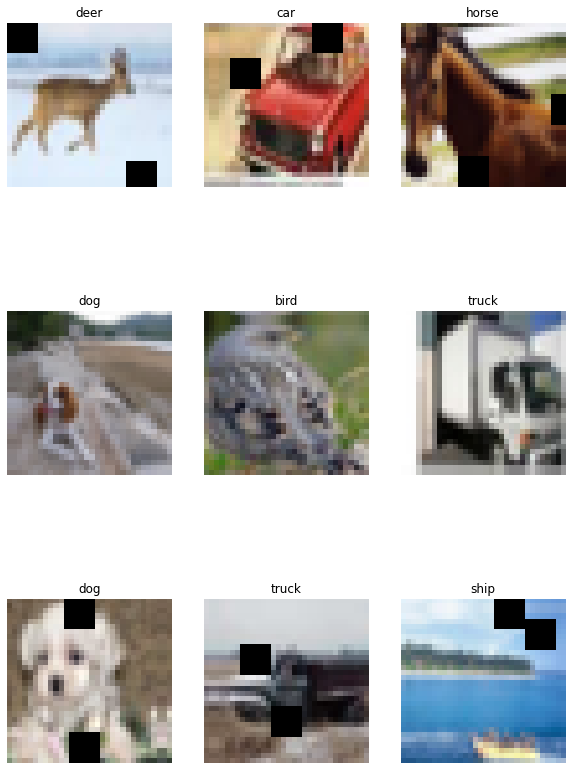

In [ ]:
#plot  n raw images 
#make sure n is a squared number 
show_images.plot_n_image(9,trainloader,classes,mean,std,format='raw')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

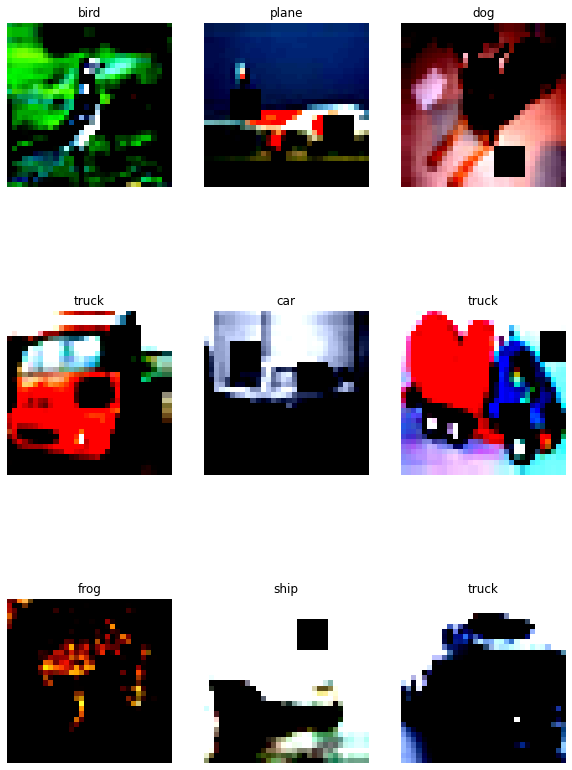

In [ ]:
#plot  n normalized images 
#make sure n is a squared number 
show_images.plot_n_image(9,trainloader,classes,mean,std,format='normalized')

In [ ]:

dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
class_count = classcount.get_train_class_count(dataset,classes)
print(class_count)

Files already downloaded and verified
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#working 
#model = BasicModel.Net().to(device)


model = RESNET.ResNet18().to(device) 
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [ ]:
#FIND BEST POSSIBLE LR 


In [ ]:
import torch.nn as nn
import torch.optim as optim
min_lr=1e-06
# criterion = nn.CrossEntropyLoss()
# optimiser = optim.SGD(model.parameters(), lr=min_lr,momentum=Args.momentum,weight_decay=Args.lambda_l2 )
# lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
# lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=100 ,step_mode="exp")

import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=min_lr,momentum=Args.momentum,weight_decay=Args.lambda_l2 )
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")


# #            start_lr (float, optional): the starting learning rate for the range test.
#                 Default: None (uses the learning rate from the optimizer).
#             end_lr (float, optional): the maximum learning rate to test. Default: 10.
#             num_iter (int, optional): the number of iterations over which the test
#                 occurs. Default: 100.
#how to decide num_iter :total train image /batchsize = 50,000/512= 97 iteration per epoch , 500 iteration means approximately 5 epochs 



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.55E-03


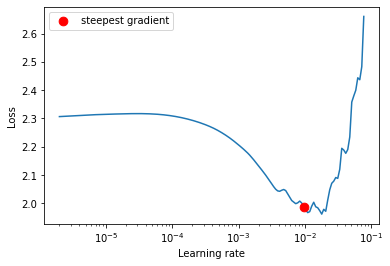

best LR With steepest descent  0.009547716114208056
best LR With minimum loss  0.01783430876931908


In [ ]:
## FIND BEST LR AND PLOT BETWEEN 10-6 and 1 

lr_finder.range_test(trainloader, val_loader=testloader,start_lr=1e-06,end_lr=1, num_iter=200 ,step_mode="exp")
_,best_descent_lr=lr_finder.plot()
## Extract Best LR with minimum losss 
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print("best LR With steepest descent ", best_descent_lr)
print("best LR With minimum loss ",Best_lr)
lr_finder.reset() # to reset the model and optimizer to their initial state

#result ideal lr at range 10-3 to 10-2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-02


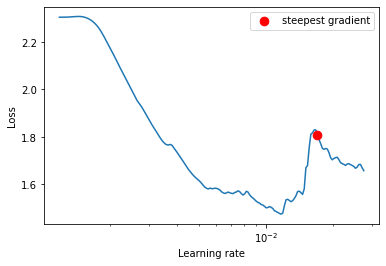

best LR With steepest descent  0.017067562383470514
best LR With minimum loss  0.011718490214585594


In [ ]:
# FIND BEST LR AND PLOT BETWEEN 10-3 and 3e10-02

lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader,start_lr=1e-03, end_lr=3e-02, num_iter=200 ,step_mode="exp")
_,best_descent_lr=lr_finder.plot()
## Extract Best LR with minimum losss 
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print("best LR With steepest descent ", best_descent_lr)
print("best LR With minimum loss ",Best_lr)
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
# so lets try with both lr to find which one works

# best LR With steepest descent  0.01992610695776011
# best LR With minimum loss  0.027548672229891

In [ ]:
#conclusion with LR 0.008  it is hardly reaching 89.87 at end of 50th epoch
#conclusion with LR 0.002

In [ ]:
#CONCLUSION FOR FINDING LR 
#I have observed though multiple experiment 
#By choosing steepest descent away from lowest will result smaller learning rate i.e 7e-03 i.e 0.007->0.008->0.009->0.10 is taking a long time to converge 
#So by choosing the largest LR with minimum loss i.e LR just before loss start increasing makes sense so choosing LR 2e-02 or 2X10-2 or 0.02 makes convergence faster
#So for CIFAR 10 LR should be 0.1 to 0.2 
#NOTE :
#here LR is not changing due to reduce LR on plateau because epoch loss is not going 

In [ ]:
#initialize loss , scheduler , optimizer 
#best_descent_lr=.009722540452645787
best_descent_lr=0.010

In [ ]:
## **Initialise Loss funtion, Optimizer, Schedular**
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_descent_lr,momentum=Args.momentum,weight_decay=Args.lambda_l2)
scheduler = ReduceLROnPlateau(optimizer, patience = 2,verbose=True)

In [ ]:
type(scheduler)

torch.optim.lr_scheduler.ReduceLROnPlateau

In [ ]:

# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
# lossfunc = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=Args.learning_rate, momentum=Args.momentum,weight_decay=Args.lambda_l2)
# scheduler = StepLR(optimizer, step_size=Args.step_size, gamma=0.1)


In [ ]:
#Test
EPOCHS = Args.epochs

EPOCHS = 50
trainer = train.Trainer()
tester  = test.Tester()
Lr_track=[]
lossfunc=criterion

for epoch in range(EPOCHS):
  print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
  Lr_track.append(optimizer.param_groups[0]['lr'])
  trainer.train(model, device, trainloader, optimizer, lossfunc, epoch, Args.lambda_l1,scheduler)
  tester.test(model, device, testloader)

test_losses,test_acc=tester.getValuesTest()
train_losses,train_acc=trainer.getValuesTrain()

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Train set: Loss=1.0106816291809082 Batch_id=97 Accuracy=58.84: 100%|██████████| 98/98 [01:04<00:00,  1.53it/s]


Epoch avarage loss for epoch 1 is 1.1359085



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -4.0387, Test Accuracy: 5650/10000 (56.50%)

EPOCH: 2 LR: 0.01


Train set: Loss=0.888940691947937 Batch_id=97 Accuracy=68.68: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 2 is 0.8777659



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -4.7626, Test Accuracy: 6383/10000 (63.83%)

EPOCH: 3 LR: 0.01


Train set: Loss=0.7782998085021973 Batch_id=97 Accuracy=74.44: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 3 is 0.7232424



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -5.7718, Test Accuracy: 7446/10000 (74.46%)

EPOCH: 4 LR: 0.01


Train set: Loss=0.6520324945449829 Batch_id=97 Accuracy=78.17: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 4 is 0.62053907



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -6.3920, Test Accuracy: 7544/10000 (75.44%)

EPOCH: 5 LR: 0.01


Train set: Loss=0.5206946134567261 Batch_id=97 Accuracy=80.85: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 5 is 0.54223377



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -6.7760, Test Accuracy: 7782/10000 (77.82%)

EPOCH: 6 LR: 0.01


Train set: Loss=0.5480456352233887 Batch_id=97 Accuracy=82.92: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 6 is 0.48813668



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -7.2890, Test Accuracy: 7825/10000 (78.25%)

EPOCH: 7 LR: 0.01


Train set: Loss=0.31308841705322266 Batch_id=97 Accuracy=84.32: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 7 is 0.44569704



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -7.8112, Test Accuracy: 8306/10000 (83.06%)

EPOCH: 8 LR: 0.01


Train set: Loss=0.46815264225006104 Batch_id=97 Accuracy=85.72: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 8 is 0.40983367



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -7.9395, Test Accuracy: 8154/10000 (81.54%)

EPOCH: 9 LR: 0.01


Train set: Loss=0.34253135323524475 Batch_id=97 Accuracy=86.81: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]


Epoch avarage loss for epoch 9 is 0.3736327



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -7.8343, Test Accuracy: 7909/10000 (79.09%)

EPOCH: 10 LR: 0.01


Train set: Loss=0.36399874091148376 Batch_id=97 Accuracy=87.89: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 10 is 0.34555143



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.1938, Test Accuracy: 8285/10000 (82.85%)

EPOCH: 11 LR: 0.01


Train set: Loss=0.3473412096500397 Batch_id=97 Accuracy=88.97: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 11 is 0.31726536



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.6148, Test Accuracy: 8408/10000 (84.08%)

EPOCH: 12 LR: 0.01


Train set: Loss=0.358398973941803 Batch_id=97 Accuracy=89.80: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 12 is 0.29426658



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -8.9644, Test Accuracy: 8150/10000 (81.50%)

EPOCH: 13 LR: 0.01


Train set: Loss=0.27603355050086975 Batch_id=97 Accuracy=90.73: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 13 is 0.2661594



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.6170, Test Accuracy: 8381/10000 (83.81%)

EPOCH: 14 LR: 0.01


Train set: Loss=0.2658504843711853 Batch_id=97 Accuracy=91.10: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 14 is 0.25369462



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -10.0902, Test Accuracy: 8569/10000 (85.69%)

EPOCH: 15 LR: 0.01


Train set: Loss=0.28359875082969666 Batch_id=97 Accuracy=91.71: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]


Epoch avarage loss for epoch 15 is 0.23582004



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -9.9233, Test Accuracy: 8328/10000 (83.28%)

EPOCH: 16 LR: 0.01


Train set: Loss=0.22832518815994263 Batch_id=97 Accuracy=92.41: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 16 is 0.2200896



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -10.4360, Test Accuracy: 8681/10000 (86.81%)

EPOCH: 17 LR: 0.01


Train set: Loss=0.1658036708831787 Batch_id=97 Accuracy=92.67: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 17 is 0.2070561



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -10.8708, Test Accuracy: 8648/10000 (86.48%)

EPOCH: 18 LR: 0.01


Train set: Loss=0.1807035654783249 Batch_id=97 Accuracy=93.39: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]


Epoch avarage loss for epoch 18 is 0.18924567



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -10.9310, Test Accuracy: 8662/10000 (86.62%)

EPOCH: 19 LR: 0.01


Train set: Loss=0.18865244090557098 Batch_id=97 Accuracy=93.62: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 19 is 0.18098433



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -11.4391, Test Accuracy: 8668/10000 (86.68%)

EPOCH: 20 LR: 0.01


Train set: Loss=0.16558519005775452 Batch_id=97 Accuracy=93.93: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 20 is 0.17236581



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -11.2374, Test Accuracy: 8738/10000 (87.38%)

EPOCH: 21 LR: 0.01


Train set: Loss=0.16517198085784912 Batch_id=97 Accuracy=94.35: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 21 is 0.16117913



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -11.6020, Test Accuracy: 8585/10000 (85.85%)

EPOCH: 22 LR: 0.01


Train set: Loss=0.18628603219985962 Batch_id=97 Accuracy=94.69: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 22 is 0.14944382



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -11.4558, Test Accuracy: 8687/10000 (86.87%)

EPOCH: 23 LR: 0.01


Train set: Loss=0.10935662686824799 Batch_id=97 Accuracy=95.01: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 23 is 0.14288849



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -11.8186, Test Accuracy: 8673/10000 (86.73%)

EPOCH: 24 LR: 0.01


Train set: Loss=0.1338103711605072 Batch_id=97 Accuracy=95.34: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 24 is 0.13224284



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -11.9553, Test Accuracy: 8771/10000 (87.71%)

EPOCH: 25 LR: 0.01


Train set: Loss=0.14532235264778137 Batch_id=97 Accuracy=95.63: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 25 is 0.12411819



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -11.8641, Test Accuracy: 8742/10000 (87.42%)

EPOCH: 26 LR: 0.01


Train set: Loss=0.16784025728702545 Batch_id=97 Accuracy=95.89: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 26 is 0.11721481



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -12.2397, Test Accuracy: 8706/10000 (87.06%)

EPOCH: 27 LR: 0.01


Train set: Loss=0.12541019916534424 Batch_id=97 Accuracy=96.11: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 27 is 0.11114309



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -12.2859, Test Accuracy: 8851/10000 (88.51%)

EPOCH: 28 LR: 0.01


Train set: Loss=0.14343342185020447 Batch_id=97 Accuracy=96.34: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]


Epoch avarage loss for epoch 28 is 0.10283713



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -12.7151, Test Accuracy: 8600/10000 (86.00%)

EPOCH: 29 LR: 0.01


Train set: Loss=0.13984397053718567 Batch_id=97 Accuracy=96.22: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 29 is 0.10503521



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -12.8682, Test Accuracy: 8714/10000 (87.14%)

EPOCH: 30 LR: 0.01


Train set: Loss=0.12687203288078308 Batch_id=97 Accuracy=96.50: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 30 is 0.100342855



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -12.6210, Test Accuracy: 8866/10000 (88.66%)

EPOCH: 31 LR: 0.01


Train set: Loss=0.05480572581291199 Batch_id=97 Accuracy=96.85: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 31 is 0.090664014



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -12.6745, Test Accuracy: 8702/10000 (87.02%)

EPOCH: 32 LR: 0.01


Train set: Loss=0.06322478502988815 Batch_id=97 Accuracy=96.93: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 32 is 0.088342585



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.1243, Test Accuracy: 8861/10000 (88.61%)

EPOCH: 33 LR: 0.01


Train set: Loss=0.11863886564970016 Batch_id=97 Accuracy=97.22: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 33 is 0.08248304



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.1340, Test Accuracy: 8846/10000 (88.46%)

EPOCH: 34 LR: 0.01


Train set: Loss=0.08867505937814713 Batch_id=97 Accuracy=97.34: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 34 is 0.077299066



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.4013, Test Accuracy: 8831/10000 (88.31%)

EPOCH: 35 LR: 0.01


Train set: Loss=0.07098089158535004 Batch_id=97 Accuracy=97.33: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 35 is 0.077045396



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -12.8630, Test Accuracy: 8929/10000 (89.29%)

EPOCH: 36 LR: 0.01


Train set: Loss=0.07767588645219803 Batch_id=97 Accuracy=97.60: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 36 is 0.07130027



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.3505, Test Accuracy: 8883/10000 (88.83%)

EPOCH: 37 LR: 0.01


Train set: Loss=0.06624940037727356 Batch_id=97 Accuracy=97.87: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 37 is 0.062900975



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.8640, Test Accuracy: 8815/10000 (88.15%)

EPOCH: 38 LR: 0.01


Train set: Loss=0.05605967715382576 Batch_id=97 Accuracy=97.89: 100%|██████████| 98/98 [01:03<00:00,  1.53it/s]


Epoch avarage loss for epoch 38 is 0.06220266



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.7173, Test Accuracy: 8938/10000 (89.38%)

EPOCH: 39 LR: 0.01


Train set: Loss=0.08468478918075562 Batch_id=97 Accuracy=97.91: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 39 is 0.061208237



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.7853, Test Accuracy: 8956/10000 (89.56%)

EPOCH: 40 LR: 0.01


Train set: Loss=0.08250335603952408 Batch_id=97 Accuracy=97.86: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 40 is 0.06355992



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.8586, Test Accuracy: 8883/10000 (88.83%)

EPOCH: 41 LR: 0.01


Train set: Loss=0.06908627599477768 Batch_id=97 Accuracy=97.87: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 41 is 0.061916087



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.4003, Test Accuracy: 8862/10000 (88.62%)

EPOCH: 42 LR: 0.01


Train set: Loss=0.0829988420009613 Batch_id=97 Accuracy=98.15: 100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch avarage loss for epoch 42 is 0.054855447



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.6747, Test Accuracy: 8964/10000 (89.64%)

EPOCH: 43 LR: 0.01


Train set: Loss=0.0656534731388092 Batch_id=97 Accuracy=98.10: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 43 is 0.05524693



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.7347, Test Accuracy: 8998/10000 (89.98%)

EPOCH: 44 LR: 0.01


Train set: Loss=0.09507112950086594 Batch_id=97 Accuracy=98.06: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 44 is 0.056570195



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.8354, Test Accuracy: 8930/10000 (89.30%)

EPOCH: 45 LR: 0.01


Train set: Loss=0.06411376595497131 Batch_id=97 Accuracy=98.10: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 45 is 0.053090446



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.8262, Test Accuracy: 8767/10000 (87.67%)

EPOCH: 46 LR: 0.01


Train set: Loss=0.06666641682386398 Batch_id=97 Accuracy=98.09: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch avarage loss for epoch 46 is 0.055170555



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -14.2839, Test Accuracy: 8989/10000 (89.89%)

EPOCH: 47 LR: 0.01


Train set: Loss=0.0314568467438221 Batch_id=97 Accuracy=98.51: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 47 is 0.04470493



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.8497, Test Accuracy: 8860/10000 (88.60%)

EPOCH: 48 LR: 0.01


Train set: Loss=0.058615248650312424 Batch_id=97 Accuracy=98.50: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 48 is 0.04455168



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -13.6901, Test Accuracy: 8913/10000 (89.13%)

EPOCH: 49 LR: 0.01


Train set: Loss=0.029378743842244148 Batch_id=97 Accuracy=98.55: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 49 is 0.04319328



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: -14.0037, Test Accuracy: 8905/10000 (89.05%)

EPOCH: 50 LR: 0.01


Train set: Loss=0.051337651908397675 Batch_id=97 Accuracy=98.60: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch avarage loss for epoch 50 is 0.040980563



Test set: Average loss: -14.1319, Test Accuracy: 8991/10000 (89.91%)



In [ ]:
new_train_acc,new_train_loss=useful_utils.modify_train_loss_accuracy_from_batch_level_to_epoch_level(train_acc,train_losses,trainloader)

train_acc_mod=new_train_acc
train_losses_mod=new_train_loss
len(train_acc_mod),len(train_losses_mod),len(new_train_loss),len(Lr_track)

(50, 50, 50, 50)

In [ ]:
import matplotlib.pyplot as plt
def plot_lr_metric(lr_metric):
    plt.figure(figsize=(7, 5))
    plt.plot(lr_metric)
    plt.title('Learning Rate')
    plt.show()


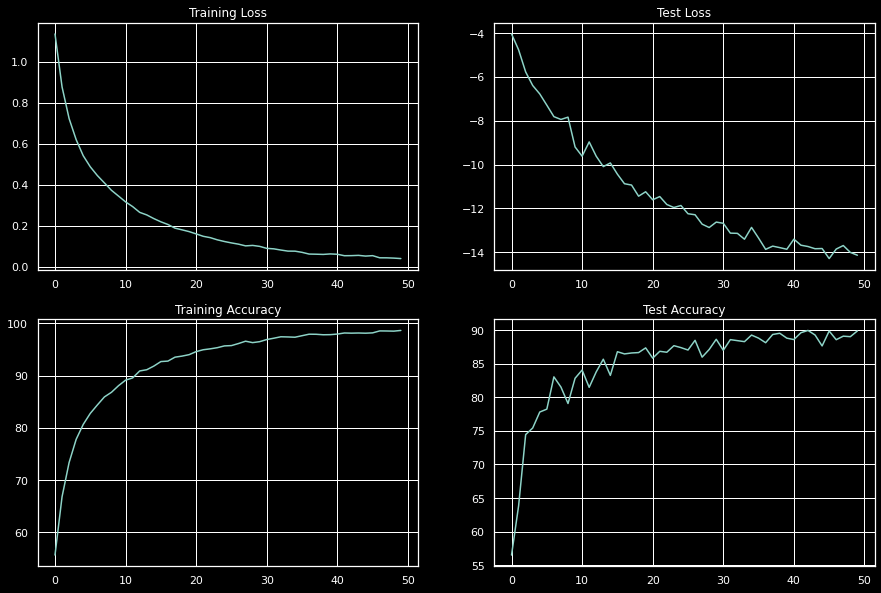

In [ ]:
def plot_train_test_loss_accuracy(train_losses_mod,train_acc_mod,test_losses,test_acc):
  import seaborn as sns
  import matplotlib.pyplot as plt
  sns.set()
  plt.style.use("dark_background")

  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses_mod)
  axs[0, 0].set_title("Training Loss")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 0].plot(train_acc_mod)
  axs[1, 0].set_title("Training Accuracy")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")
  plt.show()

plot_train_test_loss_accuracy(train_losses_mod,train_acc_mod,test_losses,test_acc)

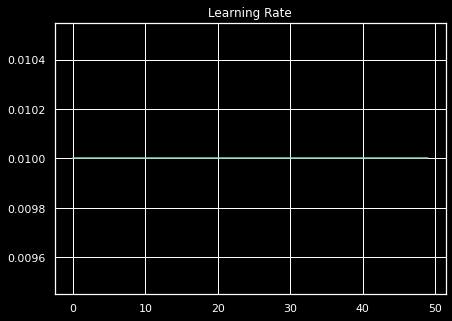

In [ ]:

plot_lr_metric(Lr_track)

In [ ]:

torch.save(model,'./data/cifar')


In [ ]:
#load the model
model = torch.load('./data/cifar')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
#GET PERCENTAGE ACCURACY FOR EACH CLASS      
perClassResult.get_percent_acc_each_class(model,device,classes,testloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 66 %
Accuracy of   cat : 83 %
Accuracy of  deer : 100 %
Accuracy of   dog : 85 %
Accuracy of  frog : 87 %
Accuracy of horse : 70 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

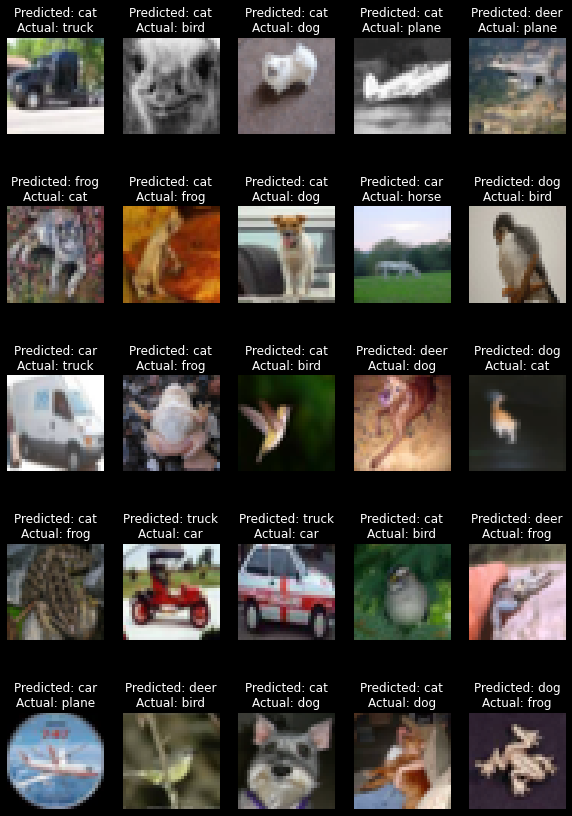

In [ ]:
#Plot misclassified Image
plot_misclassified_image.plot_misclassified(25, testloader, device,model,classes,mean,std,format='raw')

In [ ]:
## GRAD CAM 


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


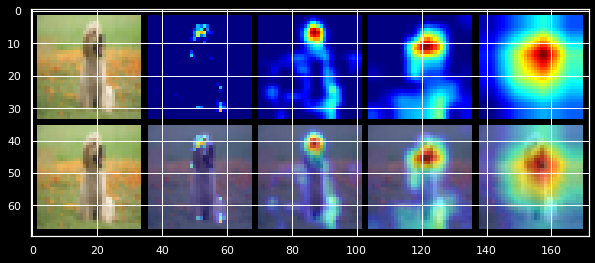

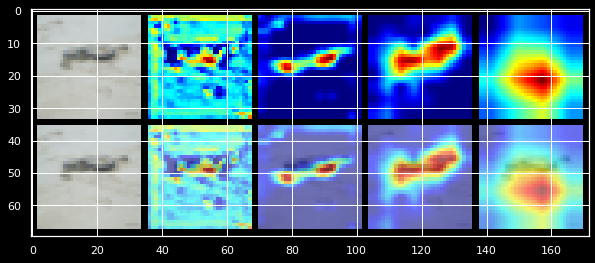

In [ ]:
#GRAD CAM for user defined images
path='/content/SWAG_DNN/img'
import PIL
img_name =[path+'/dog.jpg',path+'/snake.jpg']
gradcam.grad_cam_for_user_defined_images(img_name,device,mean,std,model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is depr

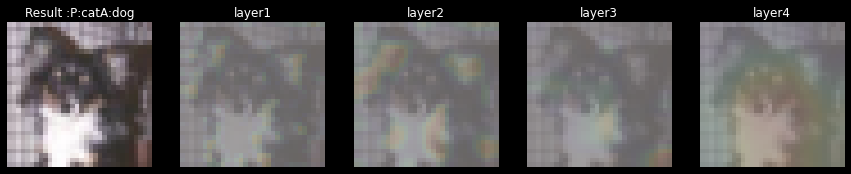

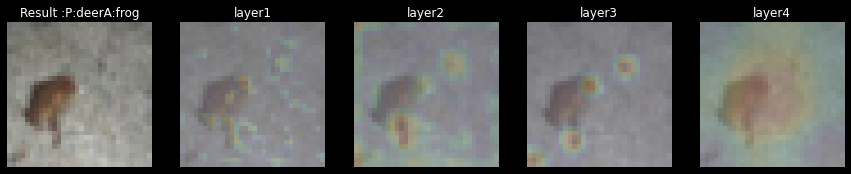

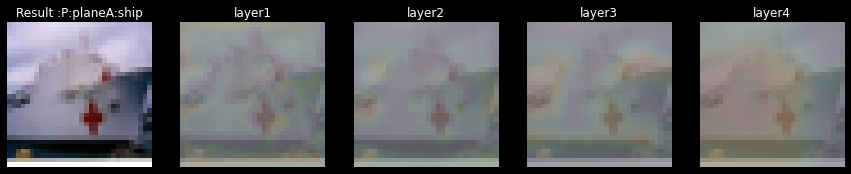

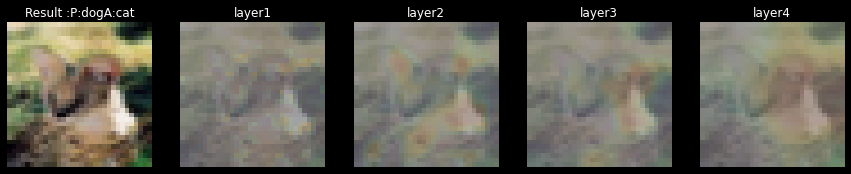

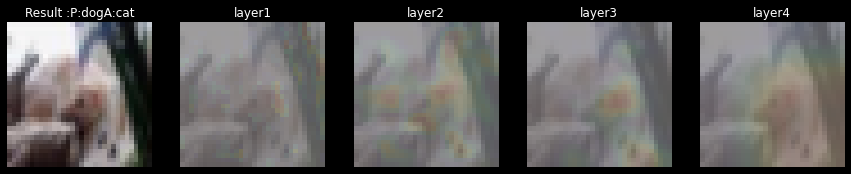

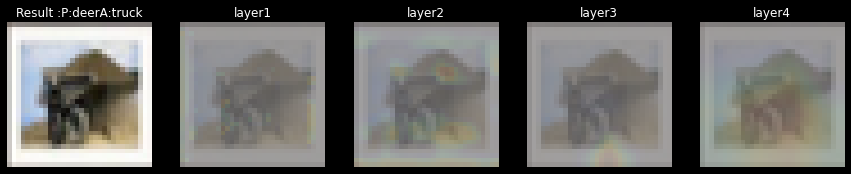

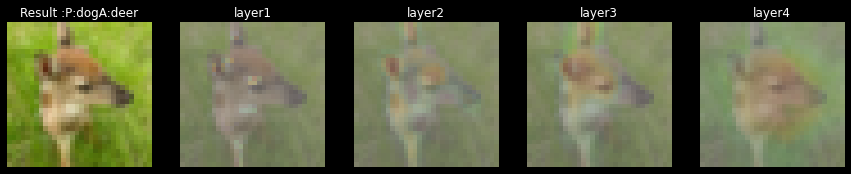

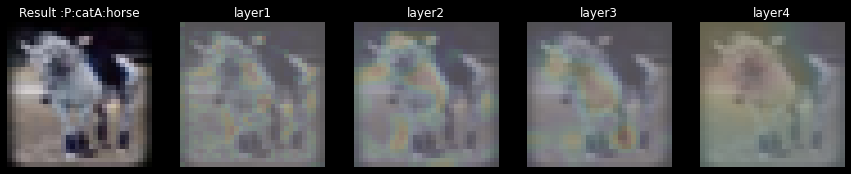

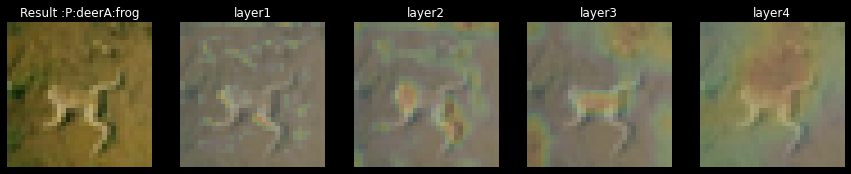

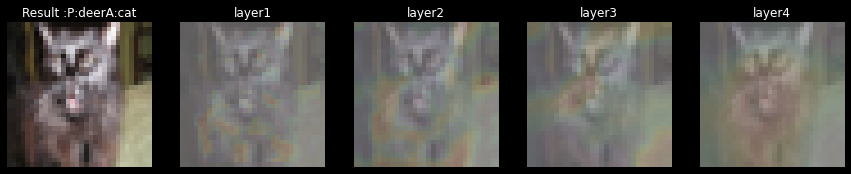

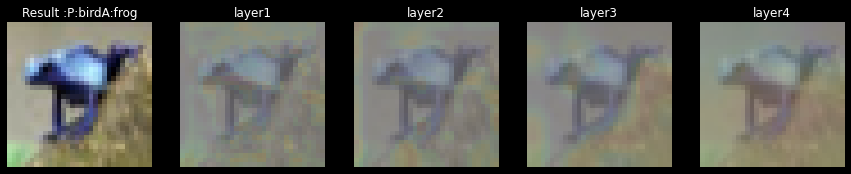

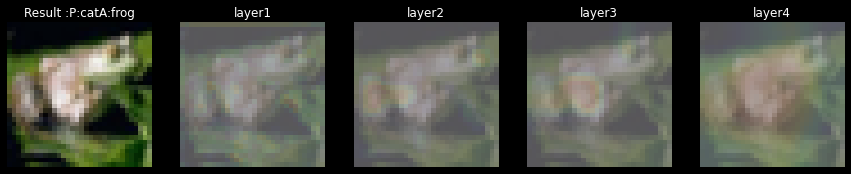

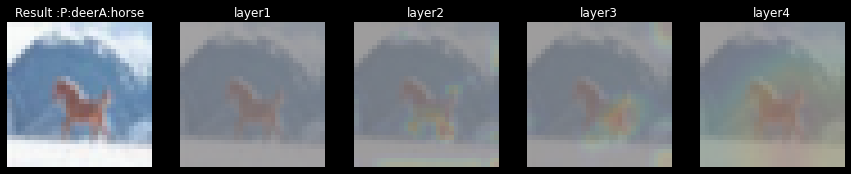

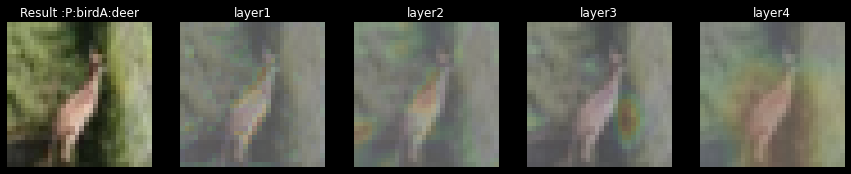

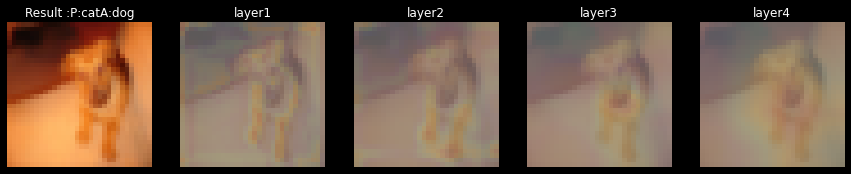

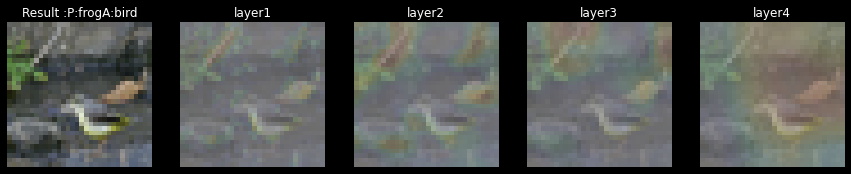

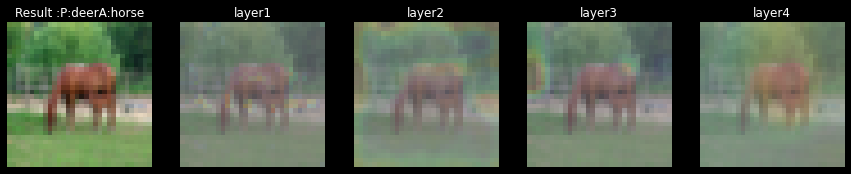

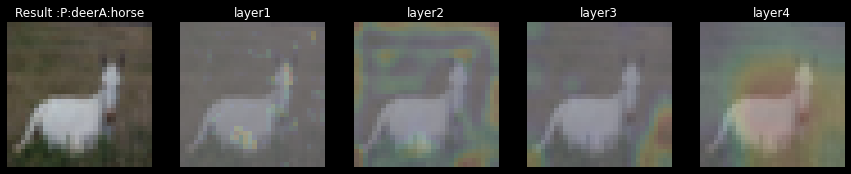

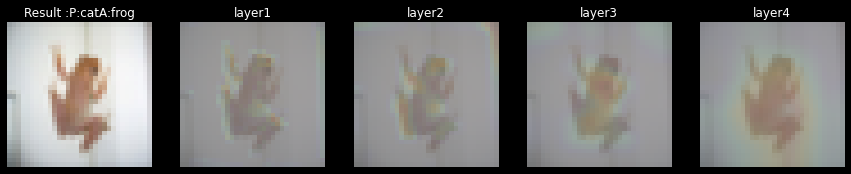

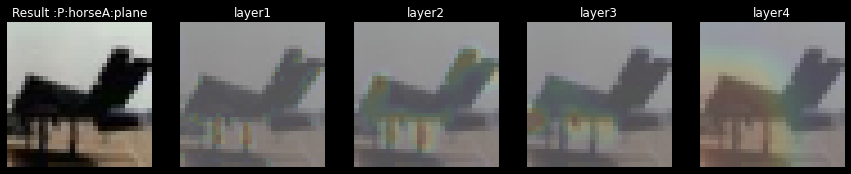

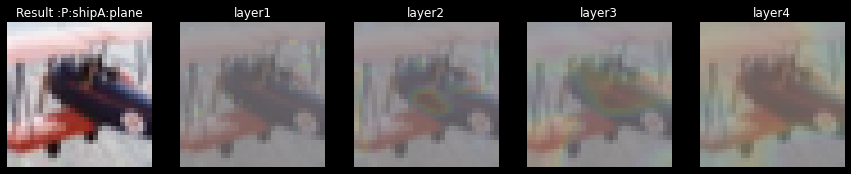

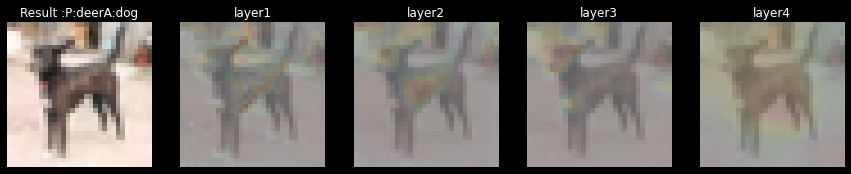

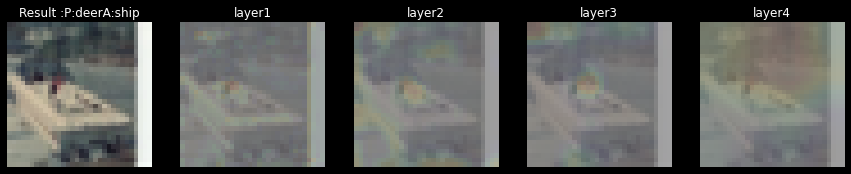

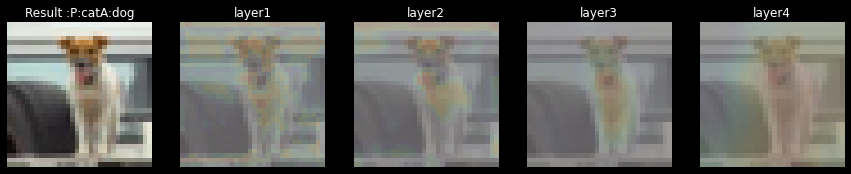

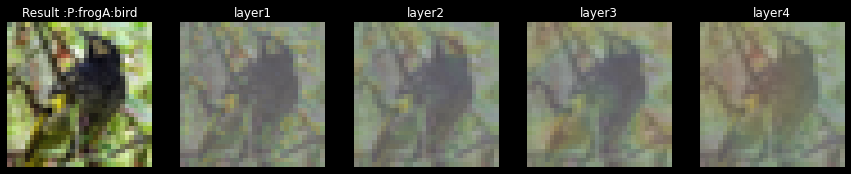

In [ ]:
missed_images, predicted, actual = plot_misclassified_image.get_misclassified(model,testloader,device)

#lets see gradcam of  4 misclassified images 
gradcam.show_gradcam_for_n_images_only_result(25,missed_images,predicted,actual,classes,model,device,mean,std)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is depr

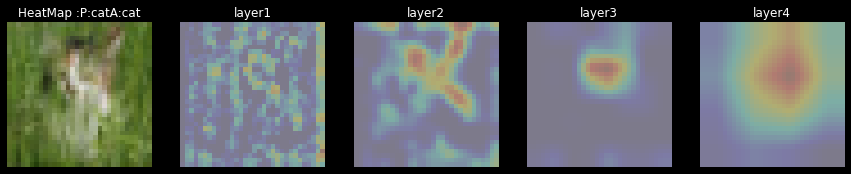

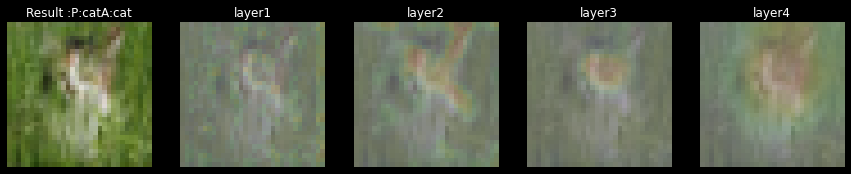

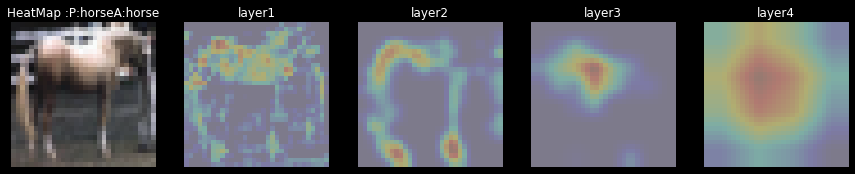

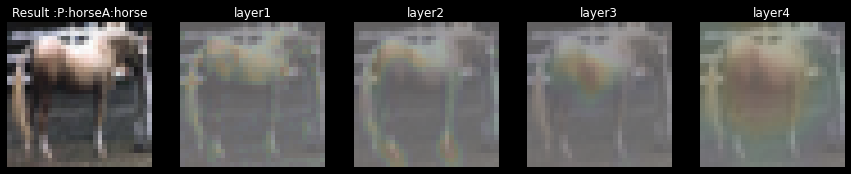

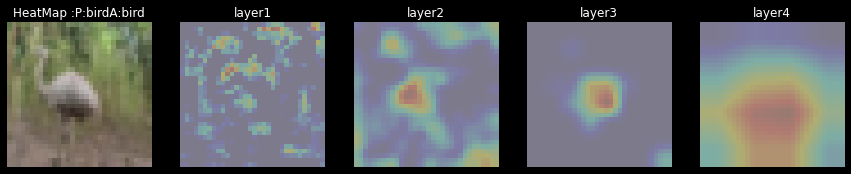

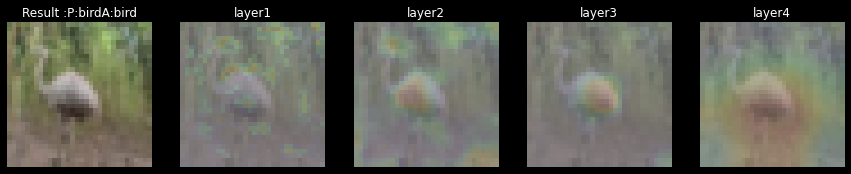

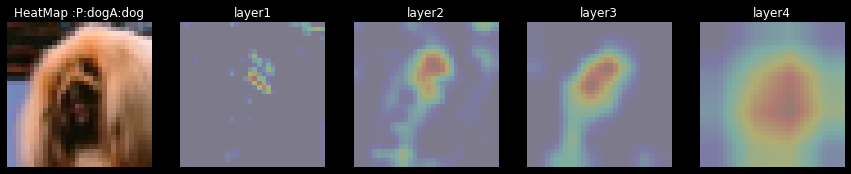

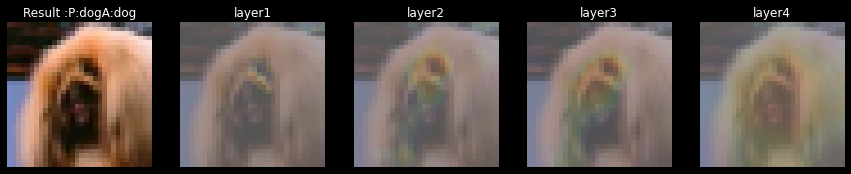

In [ ]:
proper_images, predicted, actual = plot_misclassified_image.get_properclassified(model,testloader,device)

#lets see gradcam of  4 misclassified images 
gradcam.show_gradcam_for_n_images(4,proper_images,predicted,actual,classes,model,device,mean,std)